In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
from src.transfer_learn import KinnLayer, amber_app

Using TensorFlow backend.


In [3]:
#target_wd = "outputs/2022-10-18/TL_2"
target_wd = "outputs/test_tl_amber"

In [4]:
train_hist = pd.read_table(os.path.join(target_wd, "train_history.csv"), sep=",", header=None)
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
best_arc_seq = train_hist.loc[best_trial_id, 3:].iloc[0].tolist()
# loading from h5 is not working yet
#model = tf.keras.models.load_model(
#    os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"),
#    custom_objects={"KinnLayer": KinnLayer})
train_hist.loc[best_trial_id]

,0,1,2,3,4,5,6,7,8,9,10
1,1,"[0, 0.7210029793850556]",0.721003,0,1,2,2,3,1,0,4


In [5]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2022-10-20 03:28:51,193 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [6]:
model = amb.model_fn(best_arc_seq)
model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 25, 13)]     0                                            
__________________________________________________________________________________________________
conv11 (Conv1D)                 (None, 25, 16)       224         input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 25, 16)       0           conv11[0][0]                     
__________________________________________________________________________________________________
conv27 (Conv1D)                 (None, 19, 64)       7232        dropout[0][0]                    
____________________________________________________________________________________________

In [8]:
with h5py.File("./data/inVivoData.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()], store["valid/k"][()]

In [9]:
benchmarks = {
    "Kleinsitver": amb.reward_fn(model, t1)[0],
    "Listgarten": amb.reward_fn(model, t2)[0],
    "Listgarten_Indel": amb.reward_fn(model, t3)[0],
    "Finkelstein": amb.reward_fn(model, valid_data)[0]
}

In [10]:
benchmarks

{'Kleinsitver': 0.3837633863535264,
 'Listgarten': 0.21783724478862876,
 'Listgarten_Indel': 0.25203796554152513,
 'Finkelstein': 0.7355633817909337}

In [11]:
layer_dict = {l.name:l for l in model.layers}
k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
kinetic_model = tf.keras.models.Model(
    inputs = model.inputs,
    outputs = layer_dict[k_layer_name].output
)

In [12]:
old_pred_ks = layer_dict[k_layer_name].kinn_header.predict(layer_dict[k_layer_name].mb.blockify_seq_ohe(valid_data[0][:, :, 4:]))

In [13]:
pred_k = kinetic_model.predict(valid_data[0]).flatten()

In [14]:
sess = tf.keras.backend.get_session()
old_pred_k = sess.run(layer_dict[k_layer_name].kinn_body(old_pred_ks)).flatten()

In [21]:
#ss.pearsonr(np.clip(pred_k.flatten(), -5, -1), valid_data[2])
print(
    ss.pearsonr(np.clip(pred_k, -5, -1), valid_data[2]),
    #ss.pearsonr(pred_k, valid_data[2]), 
    ss.pearsonr(np.clip(old_pred_k, -5, -1), valid_data[2])
    #ss.pearsonr(old_pred_k, valid_data[2])
)

(0.3553310311673297, 0.0) (0.880788659557428, 0.0)


In [22]:
pred_k

array([-1.7354873 , -1.0349562 , -1.2335881 , ..., -4.4195676 ,
       -6.9999995 , -0.99999994], dtype=float32)

In [17]:
valid_data[2]

array([-1.03242438, -1.15347785, -0.93014961, ..., -5.        ,
       -5.        , -5.        ])

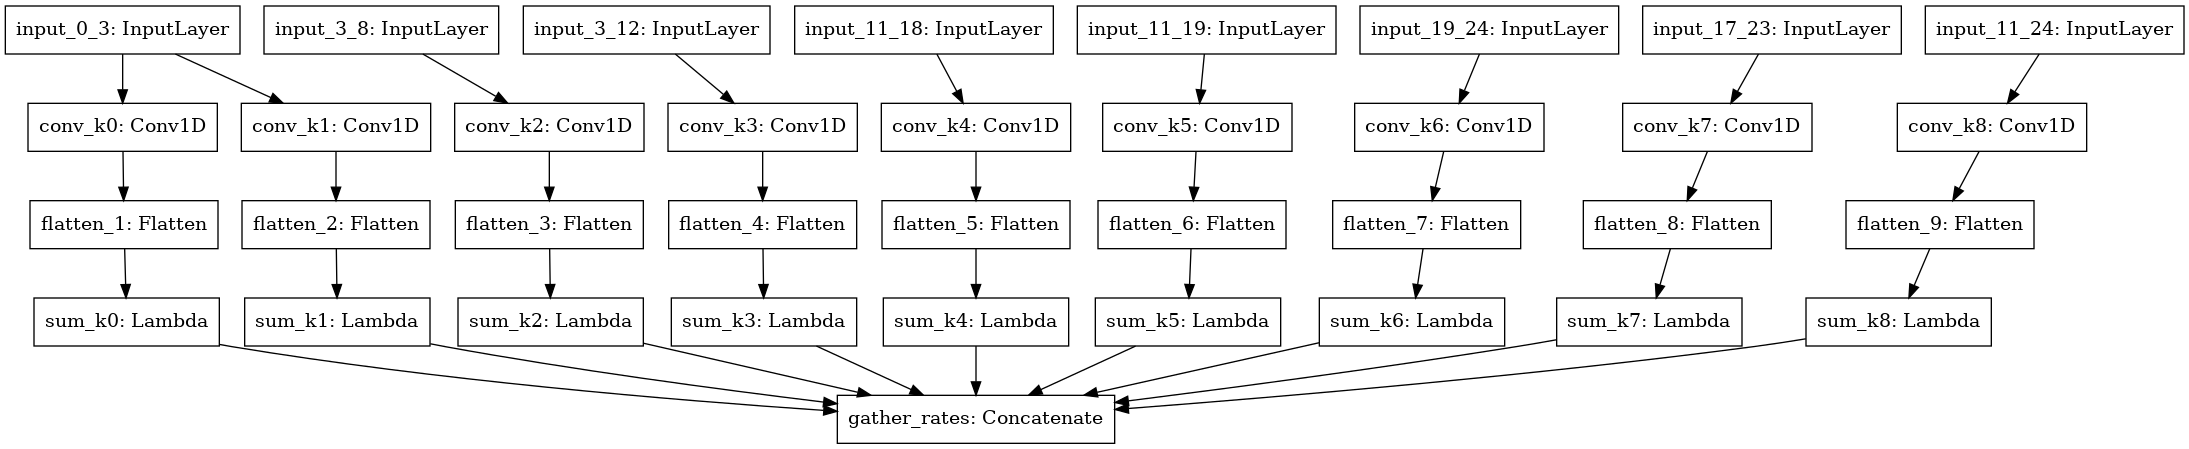

In [18]:
tf.keras.utils.plot_model(layer_dict[k_layer_name].kinn_header)

In [19]:
layer_dict["output_final"].get_weights()

[array([[1.781268]], dtype=float32), array([3.9844246], dtype=float32)]